In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

tfd = tfp.distributions
tfb = tfp.bijectors
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

# Discretized Logistic Mixture Distribution

## Single Logistic Distribution

In [4]:
vals = np.linspace(-10, 10, 1000)
len(vals)

1000

In [5]:
dist1 = tfd.Logistic(loc=1, scale=1)

In [6]:
dist1

<tfp.distributions.Logistic 'Logistic' batch_shape=[] event_shape=[] dtype=float32>

In [9]:
dist1.mean()

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [14]:
dist1.stddev()

<tf.Tensor: shape=(), dtype=float32, numpy=1.8137994>

In [17]:
dist2 = tfd.Logistic(loc=1, scale=0.25)
dist3 = tfd.Logistic(loc=1, scale=2)

### Plot distributions by different sufficient statistics

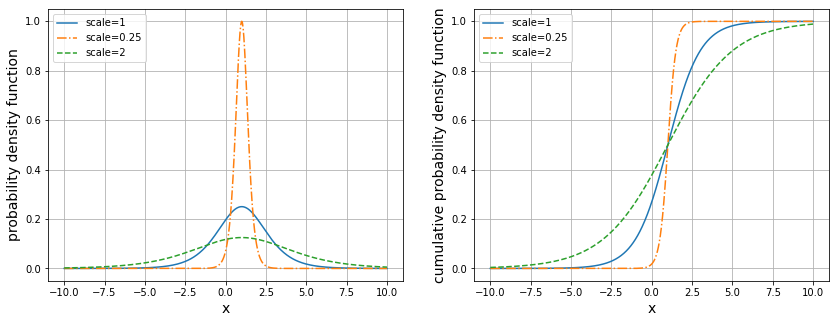

In [19]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(vals, dist1.prob(vals))
plt.plot(vals, dist2.prob(vals), ls='-.')
plt.plot(vals, dist3.prob(vals), ls='--')
plt.legend(['scale=1', 'scale=0.25', 'scale=2'], loc='upper left')
plt.xlabel('x', fontsize=14)
plt.ylabel('probability density function', fontsize=14)
plt.grid()

plt.subplot(1,2,2)
plt.plot(vals, dist1.cdf(vals)) 
plt.plot(vals, dist2.cdf(vals),ls='-.') 
plt.plot(vals, dist3.cdf(vals),ls='--') 
plt.legend(['scale=1', 'scale=0.25','scale=2'], loc='upper left')
plt.xlabel('x',fontsize=14)
plt.ylabel('cumulative probability density function',fontsize=14)
plt.grid()

plt.show()

## Discretization

TF document: https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/QuantizedDistribution

In [82]:
bits = 4
n_vals = np.linspace(0, 15, 16)
n_vals

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15.])

In [83]:
logi = tfd.Logistic(loc=1, scale=0.25)

In [84]:
discretized_logi = tfd.QuantizedDistribution(logi, low=0., high=2**bits-1.)

In [85]:
discretized_logi.prob(n_vals)

<tf.Tensor: shape=(16,), dtype=float32, numpy=
array([1.79862380e-02, 4.82013762e-01, 4.82013762e-01, 1.76508129e-02,
       3.29280912e-04, 6.03167746e-06, 1.10474019e-07, 2.02340233e-09,
       3.70599038e-11, 6.78775829e-13, 1.24322134e-14, 2.27703950e-16,
       4.17054291e-18, 7.63861617e-20, 1.39906130e-21, 2.61027905e-23],
      dtype=float32)>

<StemContainer object of 3 artists>

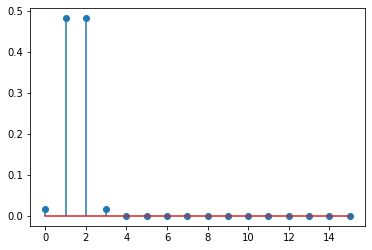

In [86]:
plt.stem(n_vals, discretized_logi.prob(n_vals))

In [87]:
vals = np.linspace(-10, 10, 1000)

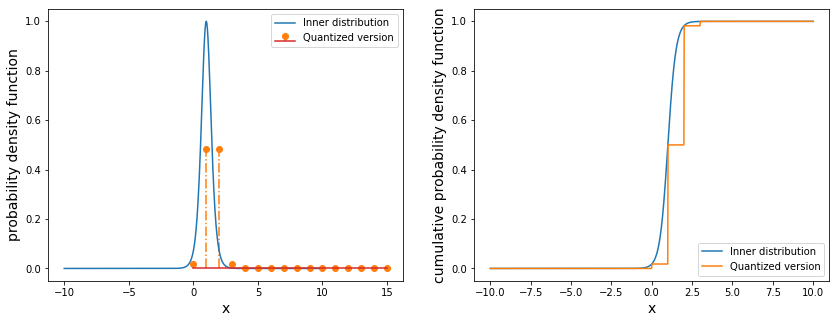

In [95]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(vals, logi.prob(vals))
plt.stem(n_vals, discretized_logi.prob(n_vals), use_line_collection=True, markerfmt='C1o',linefmt='C1-.') 
plt.legend(['Inner distribution (pdf)','Quantized version (pmf)'], loc='upper left')
plt.legend(['Inner distribution','Quantized version'], loc='upper right')
plt.xlabel('x',fontsize=14)
plt.ylabel('probability density function',fontsize=14)

plt.subplot(1,2,2)
plt.plot(vals, logi.cdf(vals)) 
plt.plot(vals, discretized_logi.cdf(vals)) 
plt.legend(['Inner distribution','Quantized version'], loc='lower right')
plt.xlabel('x',fontsize=14)
plt.ylabel('cumulative probability density function',fontsize=14)


plt.show()

In [106]:
discretized_logi.prob(1)

<tf.Tensor: shape=(), dtype=float32, numpy=0.48201376>

In [101]:
t_vals = np.linspace(0,5,10)

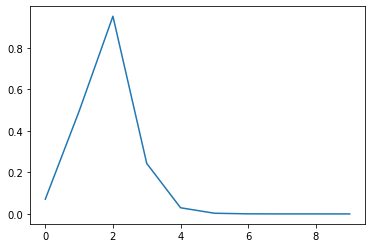

In [104]:
plt.plot(logi.prob(t_vals).numpy())

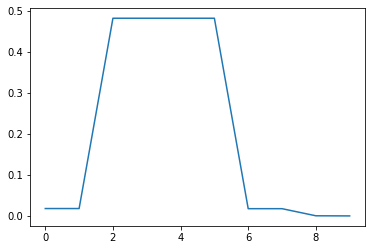

In [105]:
plt.plot(discretized_logi.prob(t_vals).numpy())

In [108]:
print(logi.sample(10))
print(discretized_logi.sample(10))

tf.Tensor(
[0.6833234  1.4298065  0.85222065 0.74566877 1.712083   1.1688051
 0.4890046  1.0672747  0.86731166 0.88988125], shape=(10,), dtype=float32)
tf.Tensor([ 1.  2.  1.  2.  2.  1.  1.  1.  1. -0.], shape=(10,), dtype=float32)


Discretized version should have summation of probabilities as 1.

In [109]:
np.sum(discretized_logi.prob(n_vals))

0.99999994

Because of ceiling, stem does not match with its original distribution, so it needs to be shifted by 0.5 to left.

In [111]:
bits = 4

logi = tfd.Logistic(loc=1, scale=0.25)
logi_shift = tfd.TransformedDistribution(distribution=logi, bijector=tfb.Shift(shift=-0.5))
discretized_logi = tfd.QuantizedDistribution(logi_shift, low=0., high=2**bits-1.)

In [112]:
vals = np.linspace(-10,10,1000) 

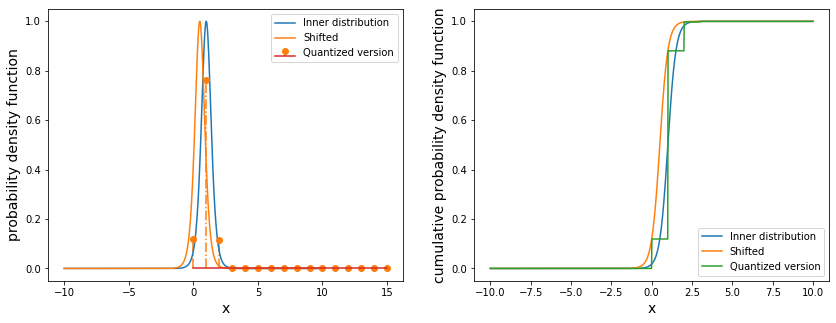

In [119]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(vals, logi.prob(vals)) 
plt.plot(vals, logi_shift.prob(vals)) 
plt.stem(n_vals, discretized_logi.prob(n_vals), use_line_collection=True, markerfmt='C1o',linefmt='C1-.') 
plt.legend(['Inner distribution','Shifted','Quantized version'], loc='upper right')
plt.xlabel('x',fontsize=14)
plt.ylabel('probability density function',fontsize=14)

plt.subplot(1,2,2)
plt.plot(vals, logi.cdf(vals)) 
plt.plot(vals, logi_shift.cdf(vals)) 
plt.plot(vals, discretized_logi.cdf(vals)) 
plt.legend(['Inner distribution','Shifted','Quantized version'], loc='lower right')
plt.xlabel('x',fontsize=14)
plt.ylabel('cumulative probability density function',fontsize=14)

plt.show()


### Mixture of logistic distributions and quantized version of the mixtures

In [120]:
locs = (4.0, 10.0)
scales = (0.25, 0.5)
probs = (0.8, 0.2)

In [121]:
dists = tfd.Logistic(loc=locs, scale=scales)
dists_tf = tfd.TransformedDistribution(dists, bijector=tfb.Shift(shift=-0.5))
quant = tfd.QuantizedDistribution(dists_tf, 0, high=2**4-1.)

In [123]:
mixture = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=probs),
    components_distribution=dists)

quant_mixture = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=probs),
    components_distribution=quant)

In [129]:
vals = np.linspace(0,15.1,1000) 

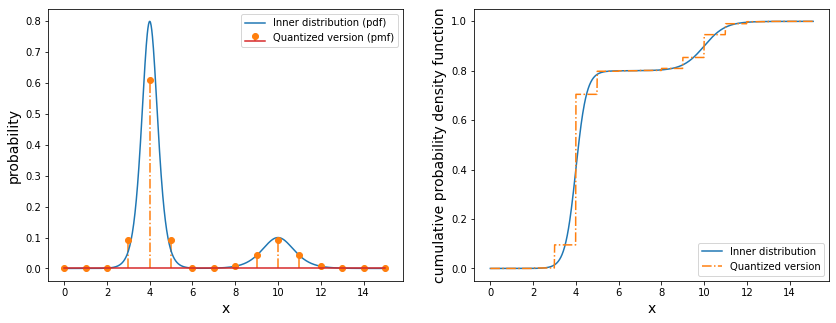

In [131]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(vals, mixture.prob(vals)) 
plt.stem(n_vals, quant_mixture.prob(n_vals), use_line_collection=True, markerfmt='C1o',linefmt='C1-.') 
plt.legend(['Inner distribution (pdf)','Quantized version (pmf)'], loc='upper right')
plt.xlabel('x',fontsize=14)
plt.ylabel('probability',fontsize=14)

plt.subplot(1,2,2)
plt.plot(vals, mixture.cdf(vals)) 
plt.plot(vals, quant_mixture.cdf(vals),ls='-.') 
plt.legend(['Inner distribution','Quantized version'], loc='lower right')
plt.xlabel('x',fontsize=14)
plt.ylabel('cumulative probability density function',fontsize=14)

plt.show()

In [139]:
np.sum(quant_mixture.prob(n_vals))

1.0

In [154]:
np.mean(dists.sample(100), axis=0)

array([ 3.9929252, 10.055092 ], dtype=float32)

In [155]:
np.mean(quant.sample(100), axis=0)

array([3.98, 9.97], dtype=float32)

In [157]:
mixture.sample(10).numpy()

array([3.4493227, 3.889775 , 3.5333676, 3.667303 , 4.586967 , 9.528755 ,
       3.6651428, 3.4861405, 4.0815496, 4.3888235], dtype=float32)

In [159]:
quant_mixture.sample(10).numpy()

array([ 4., 10.,  3.,  4.,  4.,  4.,  4.,  5.,  7.,  5.], dtype=float32)

### Using the mixture of logistics in a neural network

In [168]:
def quant_mixture_logistic(out, bits=8, num=3):  
    loc, un_scale, logits = tf.split(out,
                                     num_or_size_splits=num,
                                     axis=-1)
    print('out: ', out)
    print('LOC: ', loc)
    print('un_scale: ', un_scale)
    print('logits: ', logits)
    
    scale = tf.nn.softplus(un_scale)
    discretized_logistic_dist = tfd.QuantizedDistribution(
    distribution=tfd.TransformedDistribution(
        distribution=tfd.Logistic(loc=loc, scale=scale),
        bijector=tfb.AffineScalar(shift=-0.5)),
    low=0.,
    high=2**bits - 1.)
        
    mixture_dist = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(logits=logits), 
        components_distribution=discretized_logistic_dist)
    return mixture_dist


In [169]:
inputs = tf.keras.layers.Input(shape=(100,))  
h1 = Dense(10, activation='tanh')(inputs)
out = Dense(6)(h1)
p_y = tfp.layers.DistributionLambda(quant_mixture_logistic)(out)

out:  Tensor("Placeholder:0", shape=(None, 6), dtype=float32)
LOC:  Tensor("distribution_lambda_2/split:0", shape=(None, 2), dtype=float32)
un_scale:  Tensor("distribution_lambda_2/split:1", shape=(None, 2), dtype=float32)
logits:  Tensor("distribution_lambda_2/split:2", shape=(None, 2), dtype=float32)


In [167]:
model = Model(inputs=inputs, outputs=p_y)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 66        
_________________________________________________________________
distribution_lambda_1 (Distr multiple                  0         
Total params: 1,076
Trainable params: 1,076
Non-trainable params: 0
_________________________________________________________________
